In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ramanspy as rp
import torch

from IPython.display import clear_output

from functions.configs import *
from functions.utils import translate_confusion_matrix
from functions.data_loader import RamanDataLoader
from functions.noise_func import RamanNoiseProcessor
from functions.pipeline import RamanPipeline, MovingAverage, SNV
from functions.visualization import RamanVisualizer
from functions.ML import RamanML

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
hirushu_dir = os.getcwd() + '/test_rawdata/Tamura/引き継ぎ/ヒルシュ'
hirushu_dir

raman_raw_dir = hirushu_dir + '/raman_raw'
hirsch_dir = {}
normal_dir = {}
other_dir = {}
for l in os.listdir(raman_raw_dir):
    if "hirsch" in l:
        hirsch_dir[l] = raman_raw_dir + '/' + l
        continue

    if "normal" in l:
        normal_dir[l] = raman_raw_dir + '/' + l
        continue
    
    other_dir[l] = raman_raw_dir + '/' + l

In [ ]:
hirsch_dfs = []
m = 1
n = 1
window_size = 50
tst_hirsch_df = None
tst_normal_df = None
for k in range(1, 4):
    csv_path = os.path.join(hirushu_dir, 'データ', 'merged_data_raw', f'Case{k}', 'hirsch', 'hirsch.csv')
    loader = RamanDataLoader(csv_path)
    df = loader.data
    processor = RamanNoiseProcessor(df)
    processed_df = processor.baselineAndGaussianNoise(window_size=window_size)
    if k == m:
        tst_hirsch_df = processed_df
    else:
        hirsch_dfs.append(processed_df)
    
normal_dfs = []
for k in range(1, 4):
    csv_path = os.path.join(hirushu_dir, 'データ', 'merged_data_raw', f'Case{k}', 'normal', 'normal.csv')
    loader = RamanDataLoader(csv_path)
    df = loader.data
    processor = RamanNoiseProcessor(df)
    processed_df = processor.baselineAndGaussianNoise(window_size=window_size)
    if k == n:
        tst_normal_df = processed_df
    else:
        normal_dfs.append(processed_df)
    


Loaded Raman spectra with 19 samples and 858 data points
Auto-detected baseline region: 1752.46–1787.18 cm⁻¹
Loaded Raman spectra with 19 samples and 858 data points
Auto-detected baseline region: 1752.46–1787.18 cm⁻¹
Loaded Raman spectra with 39 samples and 858 data points
Auto-detected baseline region: 1752.46–1787.18 cm⁻¹
Loaded Raman spectra with 19 samples and 858 data points
Auto-detected baseline region: 1752.46–1787.18 cm⁻¹
Loaded Raman spectra with 49 samples and 858 data points
Auto-detected baseline region: 1752.46–1787.18 cm⁻¹
Loaded Raman spectra with 39 samples and 858 data points
Auto-detected baseline region: 1752.46–1787.18 cm⁻¹


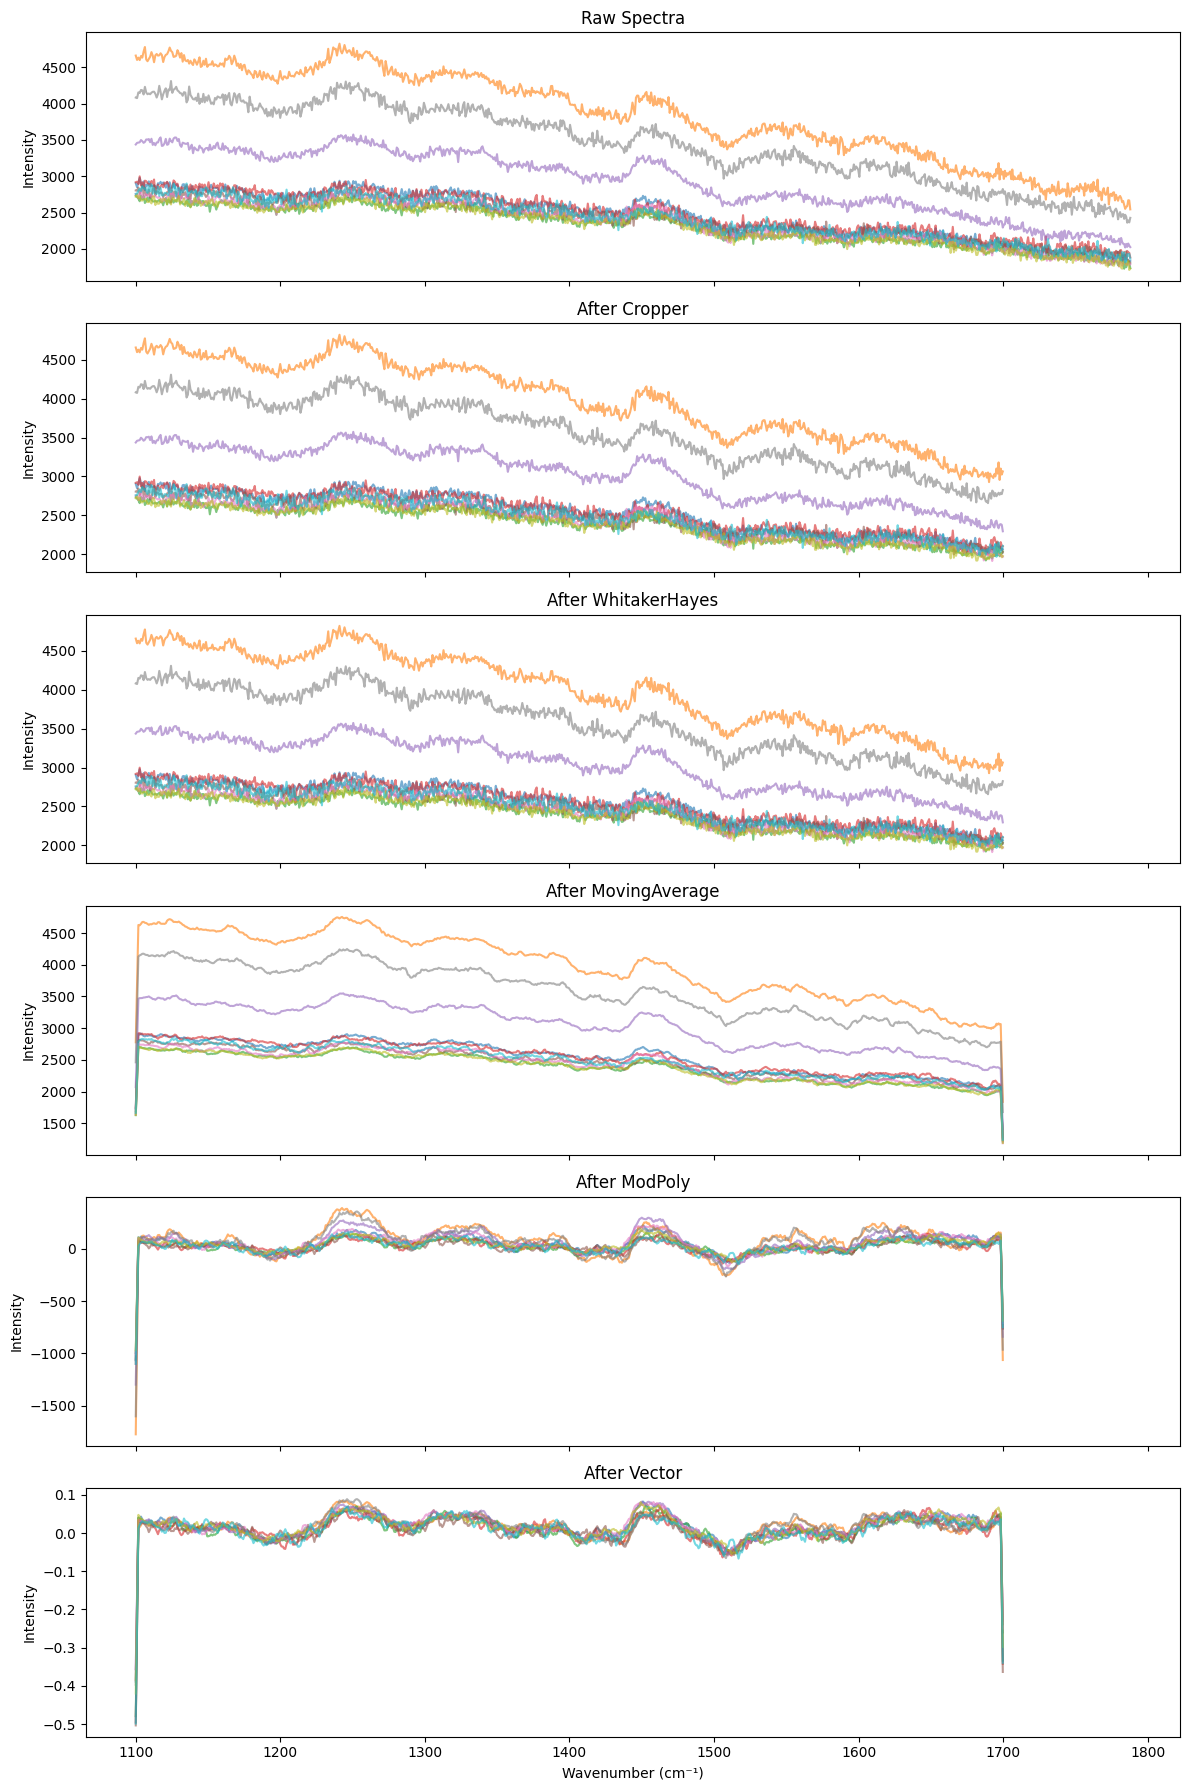

In [4]:
region = (1000, 1700) # Raman region of interest
# https://ramanspy.readthedocs.io/en/latest/preprocessing.html
# https://www.nature.com/articles/s41377-024-01394-5
preprocess_steps_test = [
        rp.preprocessing.misc.Cropper(region=region),
        rp.preprocessing.despike.WhitakerHayes(),
        MovingAverage(window_length=5),
        rp.preprocessing.baseline.ModPoly(tol=0.01),
        # rp.preprocessing.baseline.ASPLS(lam=1e5, tol=0.01),
        rp.preprocessing.normalise.Vector(),
        # SNV(),
    ]

train_hirsch_df, _, raw_train_hirsch_df = RamanPipeline().preprocess(
    dfs = hirsch_dfs,
    region = region,
    preprocessing_steps= preprocess_steps_test,
    visualize_steps=True
)


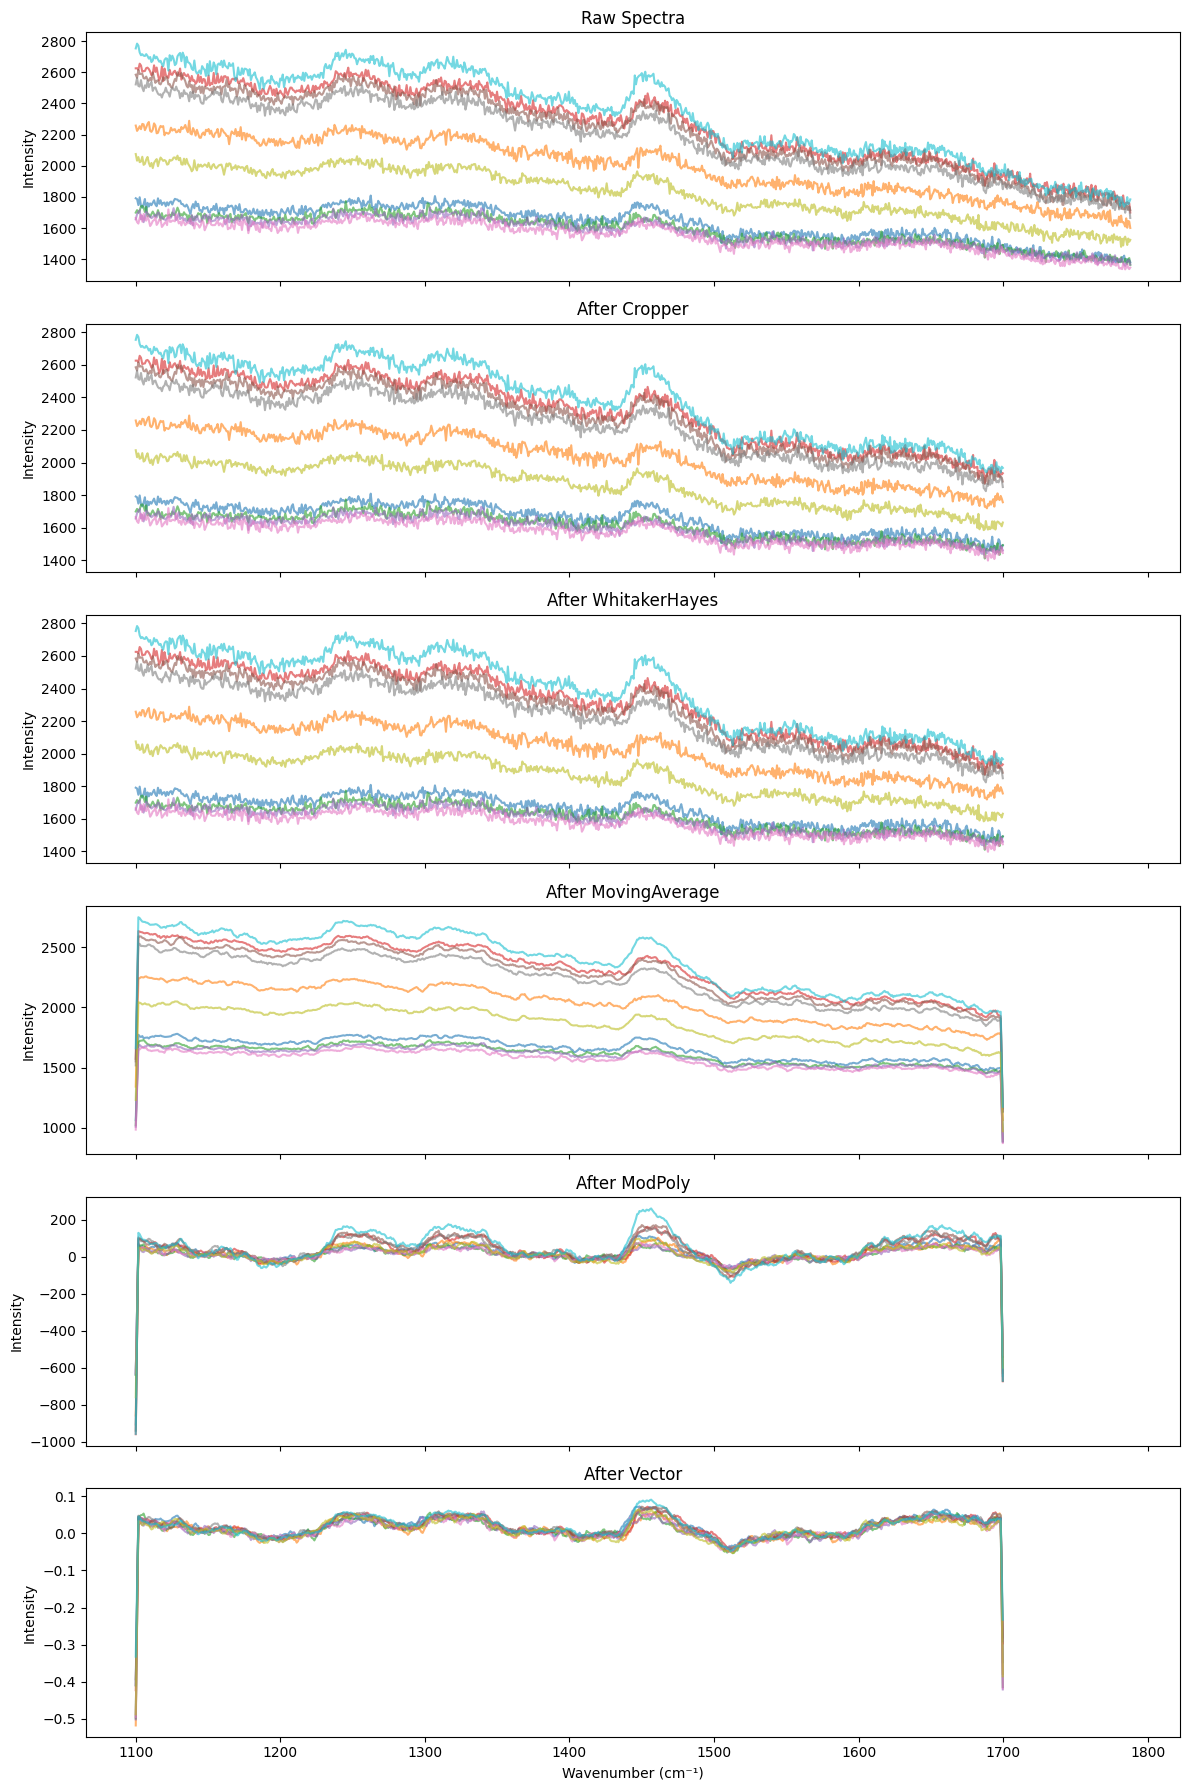

In [5]:
train_normal_df, _, raw_train_normal_df = RamanPipeline().preprocess(
    dfs = normal_dfs,
    region = region,
    preprocessing_steps= preprocess_steps_test,
    visualize_steps=True
)


In [6]:
test_svc = RamanML()
labels = ["hirsh", "normal"]

In [7]:
svc_data = test_svc.train_svc(disease_data=([train_hirsch_df], labels[0]),
        normal_data=([train_normal_df], labels[1]),param_search=True, test_size=0.4)

Interpolated (110) normal and (100) hirsh spectra to common axis.
Training SVM with 126 training samples and 84 test samples.
Performing hyperparameter tuning with GridSearchCV...


Best SVM parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}


In [8]:
pprint(translate_confusion_matrix(svc_data["confusion_matrix"], labels), indent=2)
pprint(svc_data["classification_report"], indent=2)
print(f"CV Accuracy: {svc_data['cross_val_score'].mean():.3f} ± {svc_data['cross_val_score'].std():.3f}")

{'hirsh': {'hirsh': 40, 'normal': 0}, 'normal': {'hirsh': 2, 'normal': 42}}
('              precision    recall  f1-score   support\n'
 '\n'
 '      normal       0.95      1.00      0.98        40\n'
 '       hirsh       1.00      0.95      0.98        44\n'
 '\n'
 '    accuracy                           0.98        84\n'
 '   macro avg       0.98      0.98      0.98        84\n'
 'weighted avg       0.98      0.98      0.98        84\n')
CV Accuracy: 0.992 ± 0.025


In [9]:
test_hirsch_df, _, raw_test_hirsch_df = RamanPipeline().preprocess(
    dfs = [tst_hirsch_df],
    region = region,
    preprocessing_steps= preprocess_steps_test,
    visualize_steps=False
)

In [10]:
test_normal_df, _, raw_test_normal_df = RamanPipeline().preprocess(
    dfs = [tst_normal_df],
    region = region,
    preprocessing_steps= preprocess_steps_test,
    visualize_steps=False
)

In [17]:
predict_data = test_svc.predict_svc(
    test_spectra=[test_hirsch_df],
    # model = svc_data["model"]
)

predict_data

Predicting 20 test samples with 735 features.


{'label_percentages': {np.str_('normal'): 1.0},
 'most_common_label': np.str_('normal'),
 'y_pred': array(['normal', 'normal', 'normal', 'normal', 'normal', 'normal',
        'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
        'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
        'normal', 'normal'], dtype='<U6')}